# Co-localization

This notebook is for co-localization analysis in RIBOmap dataset including obtaining the p-value matrix and analysis based on the p-values. 

In [15]:
# Load libraries

import numpy as np
from copy import copy, deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed
import tifffile
import scanpy as sc
from starmap.sequencing import *
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from spatial_funcs import *
from scipy.stats import *

# Input

In [16]:
# IO path
fpath = 'Z:/Data/Analyzed/2022-02-02-Hu-Hela_FUCCI'
rpath = 'Z:/Connie/RIBOmap/result/FUCCI data'
sample = 'starmap'
sample_list = ['RIBOmap', 'STARmap']
# adata
adata = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_02-22-22.h5ad'.format(sample))

In [13]:
# genes
genes = adata.var.index
genesToIndex = genes_to_index(genes)

In [14]:
# coding genes
coding_info = pd.read_excel('Z:/Connie/RIBOmap/gene_modules/TEMPOmap non-coding RNA.xlsx')
coding_genes = coding_info[coding_info['Non-coding RNA']==0]['Gene'].values # 988
non_coding_genes = coding_info[coding_info['Non-coding RNA']==1]['Gene'].values
genes_coding = genes[np.isin(genes, coding_genes)] # 981
genes_coding_flt = genes[np.logical_and(adata.var['coding'], adata.var['filter'])]

In [17]:
# color bar expression
greys = plt.get_cmap('Greys')

expr_col_coding = dict()
X_filtered_coding = dict()
for s in sample_list:
    X_s = adata.X[np.logical_and(adata.obs['sample']==s, adata.obs['pass_all_filters'])] 
    X_s = X_s[:, np.logical_and(adata.var['filter'], adata.var['coding'])]
    X_filtered_coding[s] = X_s
    mean_expr = np.mean(X_s, axis=0)
    # mean_expr_norm = Normalizer(norm='max').fit_transform(mean_expr.reshape(1,-1))
    mean_expr_norm = zscore(mean_expr) + 0.5
    # cmap = viridis(mean_expr_norm)
    cmap = greys(mean_expr_norm)
    expr_col_coding[s] = cmap

C:\Users\wangk\.conda\envs\connie\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wangk\.conda\envs\connie\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
# points, bases
genes2seqs, seqs2genes = load_genes(fpath)
mat_bases, mat_points = load_reads_3D(os.path.join(fpath, 'merged_spots', sample), 'merged_goodPoints_max3d.mat')
points = mat_points.astype(int)
bases = np.array([seqs2genes[x] for x in mat_bases])

In [ ]:
# points converted real coordinates
points_real = np.concatenate(((points[:,0]/30*10.2735).reshape(points.shape[0],1), points[:,1:]/3072*290.7187), axis=1)

In [ ]:
# segmentation, rtc
cell = tifffile.imread(os.path.join(fpath, 'segmentation', sample, 'cell.tif'))
rtc = cell[points[:,0], points[:,1], points[:,2]] # 1-indexed (0==background)

# Run

In [ ]:
# filter cells
rtc_flt = rtc[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]
points_real_flt = points_real[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]
bases_flt = bases[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]

In [ ]:
# filtered
genes_ = list(genes)
bases_ind = np.array([genes_.index(g) for g in bases_flt])
n_perm = 500
n_jobs = 8
radius = 3
record = rnn_parallel(len(genes), points_real_flt, bases_ind, rtc_flt, rad=radius, 
                        n_perm=n_perm, n_jobs=n_jobs)

In [ ]:
# np.save('/stanley/WangLab/Connie/RIBOmap/result/FUCCI data/rnn_r3_{}_03-10-test'.format(sample), record)

# Result

In [5]:
ribo_rnn = np.load(rpath+'/co-localization/rnn/rnn_r3_ribomap_03-10-1000.npy')
star_rnn = np.load(rpath+'/co-localization/rnn/rnn_r3_starmap_03-10-1000.npy')

<AxesSubplot:>

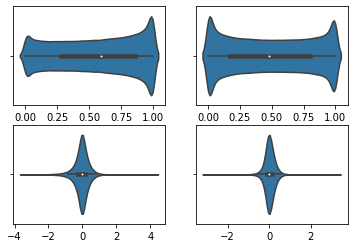

In [8]:
fig, ax = plt.subplots(2,2)
sns.violinplot(x=ribo_rnn[1], ax=ax[0,0])
sns.violinplot(x=star_rnn[1], ax=ax[0,1])
sns.violinplot(x=ribo_rnn[2], ax=ax[1,0])
sns.violinplot(x=star_rnn[2], ax=ax[1,1])

In [18]:
# keep coding & filtered genes only
rtemp = ribo_rnn[1][np.isin(genes, genes_coding_flt)]
ribo_rnn_flt = rtemp[:, np.isin(genes, genes_coding_flt)]
stemp = star_rnn[1][np.isin(genes, genes_coding_flt)]
star_rnn_flt = stemp[:, np.isin(genes, genes_coding_flt)] 

C:\Users\wangk\.conda\envs\connie\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.0, 'STARmap')

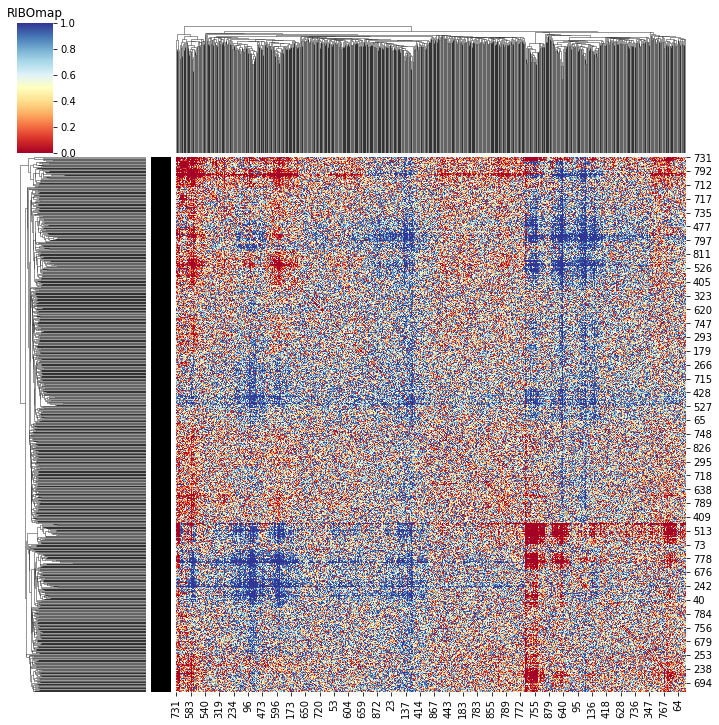

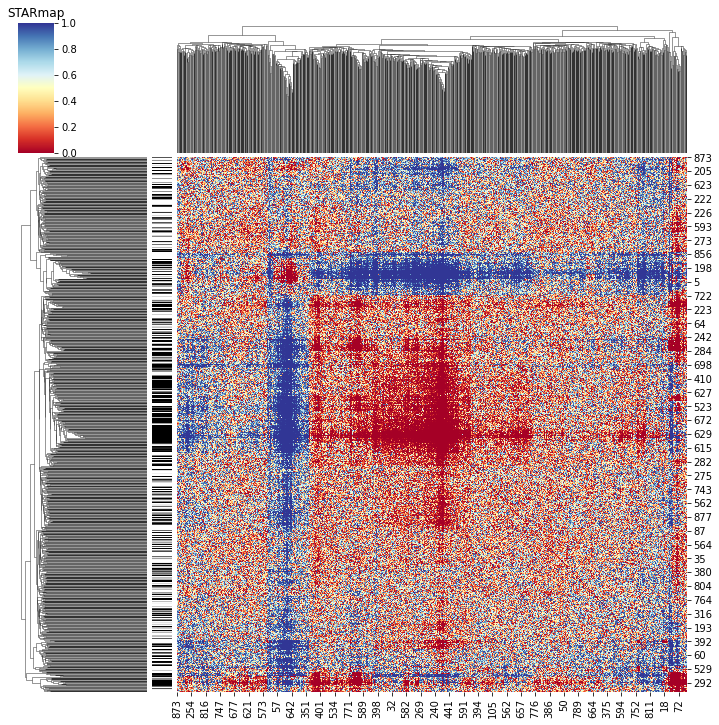

In [19]:
sns.clustermap(ribo_rnn_flt, row_colors=expr_col_coding['RIBOmap'], cmap='RdYlBu')
plt.title('RIBOmap')
sns.clustermap(star_rnn_flt, row_colors=expr_col_coding['STARmap'], cmap='RdYlBu')
plt.title('STARmap')

## order STAR as RIBO

In [20]:
mRIBO, lo_rnn, fig_rnn_ribo = cluster_ordered_matrix(ribo_rnn_flt, ribo_rnn_flt, genes_coding_flt, n_clusters=10, plotly=True, title='RIBOmap', zmin=0, zmax=1)
mSTAR, lo_rnn, fig_rnn_star = cluster_ordered_matrix(ribo_rnn_flt, star_rnn_flt, genes_coding_flt, n_clusters=10, plotly=True, title='STARmap', zmin=0, zmax=1)
# fig_rnn_ribo.write_html(rpath+'/figures/co-localization/ribo_rnn_03-13.html')
# fig_rnn_star.write_html(rpath+'/figures/co-localization/star_rnn_03-13.html')
# pd.DataFrame(lo_rnn).to_csv(rpath+'/figures/co-localization/rnn_cluster_order_03-13.csv')

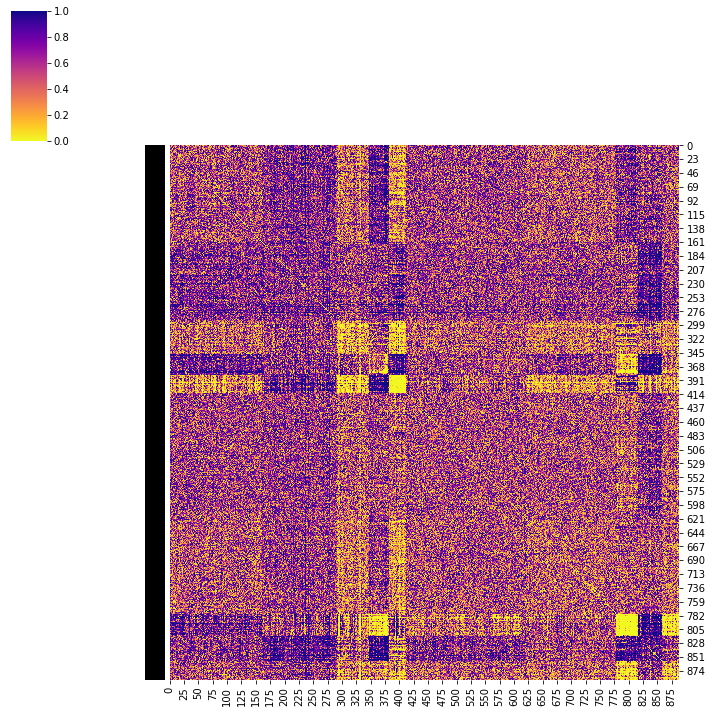

In [21]:
fig = sns.clustermap(mRIBO, row_cluster=False, col_cluster=False, row_colors=expr_col_coding['RIBOmap'], 
                vmin=0, vmax=1, cmap='plasma_r')
# fig.figure.savefig(rpath+'/figures/co-localization/ribomap.pdf')

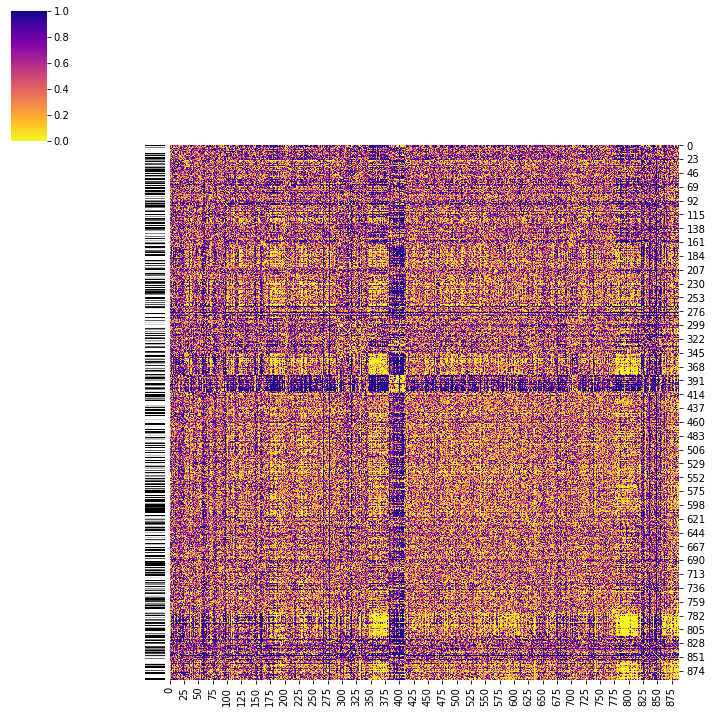

In [22]:
fig = sns.clustermap(mSTAR, row_cluster=False, col_cluster=False, row_colors=expr_col_coding['STARmap'], 
                vmin=0, vmax=1, cmap='plasma_r')
# fig.figure.savefig(rpath+'/figures/co-localization/starmap_asRIBO.pdf')